# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение, чтобы привлечь новых клиентов. В нём можно будет узнать рыночную стоимость своего автомобиля. 
Необходимо построить модель, которая умеет её определять. В нашем распоряжении данные о технических характеристиках, комплектации и ценах других автомобилей.

Критерии, которые важны заказчику:
- качество предсказания;
- время обучения модели;
- время предсказания модели.

### Описание данных

Признаки

- *DateCrawled* — дата скачивания анкеты из базы
- *VehicleType* — тип автомобильного кузова
- *RegistrationYear* — год регистрации автомобиля
- *Gearbox* — тип коробки передач
- *Power* — мощность (л. с.)
- *Model* — модель автомобиля
- *Kilometer* — пробег (км)
- *RegistrationMonth* — месяц регистрации автомобиля
- *FuelType* — тип топлива
- *Brand* — марка автомобиля
- *Repaired* — была машина в ремонте или нет
- *DateCreated* — дата создания анкеты
- *NumberOfPictures* — количество фотографий автомобиля
- *PostalCode* — почтовый индекс владельца анкеты (пользователя)
- *LastSeen* — дата последней активности пользователя

Целевой признак

- *Price* — цена (евро)

## Загрузка данных

In [4]:
import pandas as pd  # Импортируем все необходимые библиотеки для работы
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.dummy import DummyRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor

from catboost import CatBoostRegressor 
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor


In [5]:
try:  # Загрузка данных
    df = pd.read_csv('/datasets/autos.csv')
except:
    df = pd.read_csv('autos.csv')

In [6]:
df.info()  # Вывод общей информации на экран

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [7]:
df.columns = ['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type', 'brand',
       'repaired', 'date_created', 'number_of_pictures', 'postal_code',
       'last_seen']  # Изменим названия столбцов в соответствии со snake_case

In [8]:
df.head()  # Выведем первые 5 строк датафрейма на экран для ознакомления

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


## Изучение и обработка данных

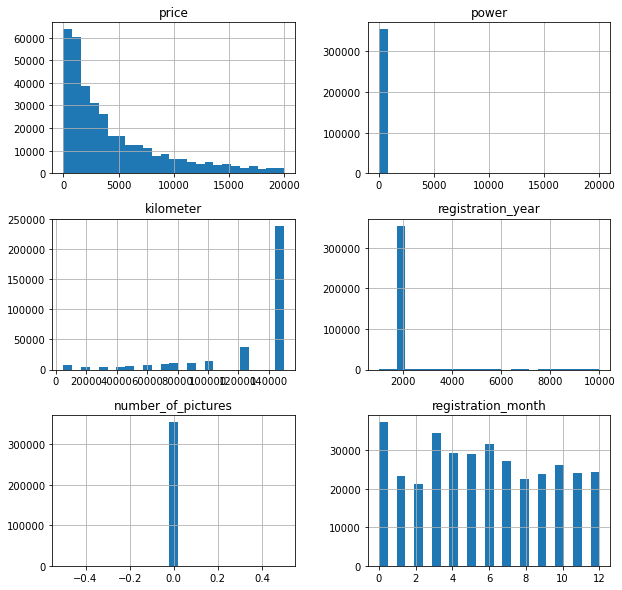

In [9]:
df[['price', 'power', 'kilometer','registration_year', 'number_of_pictures', 'registration_month']
  ].hist(figsize=(10,10), bins=25);  # Гистограммы количественных признаков

Из гистограмм следует, что столбец 'number_of_pictures' содержит только нули; в столбцах 'power' и 'registration_year' содержатся выбросы; в столбце 'registration_month' присутствует 0-й месяц.

Для категориальных признаков построим plot.pie. Но для начала выделим категорию 'Other' в значениях 'fuel_type' для более четкого отображения результатов.

In [10]:
fuel = df['fuel_type'].value_counts().nlargest(2)
fuel_2 = pd.Series([df['fuel_type'].value_counts().sum() - fuel.sum()])
fuel_2.index = ['Other']
fuel = fuel.append(fuel_2)

C:\Users\Ksiy\AppData\Local\Temp\ipykernel_10260\1435667991.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fuel = fuel.append(fuel_2)


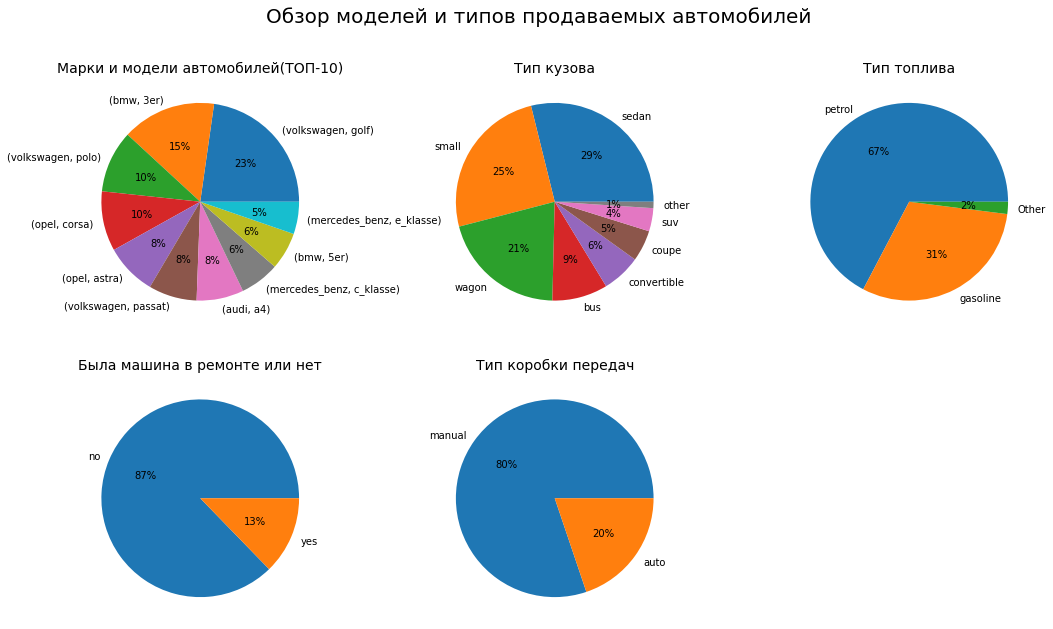

In [11]:
fig = plt.figure(figsize =(18,10))
fig.suptitle('Обзор моделей и типов продаваемых автомобилей',fontsize=20)
    
plt.subplot(2, 3, 1)
df[['brand', 'model']].value_counts().head(10).plot(kind='pie',autopct='%1.0f%%', ylabel='');
 
plt.title('Марки и модели автомобилей(ТОП-10)', fontsize=14)

plt.subplot(2, 3, 2)
df['vehicle_type'].value_counts().plot(kind='pie',autopct='%1.0f%%', ylabel='');
plt.title('Тип кузова', fontsize=14)
    
plt.subplot(2, 3, 3)
fuel.plot(kind='pie',autopct='%1.0f%%', ylabel='');
plt.title('Тип топлива', fontsize=14);

plt.subplot(2, 3, 4)
df['repaired'].value_counts().plot(kind='pie', ylabel='', autopct='%1.0f%%')
plt.title('Была машина в ремонте или нет', fontsize=14);

plt.subplot(2, 3, 5)
df['gearbox'].value_counts().plot(kind='pie', ylabel='', autopct='%1.0f%%')
plt.title('Тип коробки передач', fontsize=14);

In [12]:
df[['power', 'registration_year', 'price', 'kilometer']].describe()  # Посмотрим на выбросы в данных

,power,registration_year,price,kilometer
count,354369.000000,354369.000000,354369.000000,354369.000000
mean,110.094337,2004.234448,4416.656776,128211.172535
std,189.850405,90.227958,4514.158514,37905.341530
min,0.000000,1000.000000,0.000000,5000.000000
25%,69.000000,1999.000000,1050.000000,125000.000000
50%,105.000000,2003.000000,2700.000000,150000.000000
75%,143.000000,2008.000000,6400.000000,150000.000000
max,20000.000000,9999.000000,20000.000000,150000.000000


In [13]:
df = df.query('(1930 < registration_year < 2017) and (0 < power < 5000) and price > 10')  # Удалим выбросы и аномалии

In [14]:
df.shape  # Размер получившегося датафрейма

(296106, 16)

In [15]:
df.duplicated().sum()  # Проверим на наличие дубликатов

4

In [16]:
df = df.drop_duplicates()  # Удалим дубликаты
df.duplicated().sum()

0

Для выявления линейной зависимости количественных признаков и целевого признака воспользуемся матрицей корреляции:

In [17]:
df[['price','kilometer', 'power', 'registration_year',]].corr()  

,price,kilometer,power,registration_year
price,1.000000,-0.387136,0.389119,0.483223
kilometer,-0.387136,1.000000,0.083356,-0.288705
power,0.389119,0.083356,1.000000,0.102070
registration_year,0.483223,-0.288705,0.102070,1.000000


Из результатов следует наличие умеренной зависимости между количественными признаками и  целевым признаком. Для дальнейшей работы удалим столбцы с датой создания объявления, даты скачивания анкеты из базы, даты последнего посещения сайта владельцем, почтовый индекс владельца. Эти данные не являются значимыми при обучении модели. Кроме того, удалим столбец 'number_of_pictures', так как он содержит только нули.

In [18]:
df = df.drop(['date_crawled', 'date_created', 'number_of_pictures', 'postal_code', 'last_seen'],axis=1)

In [19]:
df.isna().sum()  # Проверим наличие пропусков в признаках

price                     0
vehicle_type          10933
registration_year         0
gearbox                5343
power                     0
model                 11147
kilometer                 0
registration_month        0
fuel_type             15469
brand                     0
repaired              42785
dtype: int64

В категориальных данных датасета содержится большое количество пропусков, если удалить, удалится более 30% всех данных. При этом достоверной информацией о том, чем заполнять эти пропуски, мы не обладаем. Для корректной работы алгоритмов обучения, заполним все пропущенные значения заглушкой 'unknown'.

In [20]:
df = df.fillna('unknown')
df.shape

(296102, 11)

In [21]:
df.isna().sum()

price                 0
vehicle_type          0
registration_year     0
gearbox               0
power                 0
model                 0
kilometer             0
registration_month    0
fuel_type             0
brand                 0
repaired              0
dtype: int64

Есть гипотеза о том, что для разных возрастов машин - своё ценообразование. Введем новый столбец - 'тип возраста', в соответствии с классификацией Международной федерации старинных автомобилей:

In [22]:
k=[]
for i in df['registration_year']:
    if 1930 < i <= 1945:
        k.append('retro_class_d')
    if 1945 < i <= 1960:
        k.append('retro_class_e')
    if 1960 < i <= 1970:
        k.append('retro_class_f')
    if 1970 < i <= 2000:
        k.append('retro_class_g')
    if i > 2000 and i <= 2012:
        k.append('old')
    if i > 2012:
        k.append('new')
df['age_type'] = k

In [23]:
df.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,age_type
1,18300,coupe,2011,manual,190,unknown,125000,5,gasoline,audi,yes,old
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown,old
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,old
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,old
5,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,retro_class_g


## Подготовка выборок для обучения модели

In [24]:
X = df.drop('price', axis=1) 
y = df['price']

In [25]:
X_train_all, X_test, y_train_all, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_all, y_train_all, test_size=0.2, random_state=10)

In [26]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(X_valid.shape)

(189504, 11)
(59221, 11)
(189504,)
(47377, 11)


In [27]:
def rmse(y_true, y_pred):  # функция расчета метрки RMSE
    error = (y_true - y_pred) ** 2
    return np.sqrt(np.mean(error))

rmse_scorer = make_scorer(rmse, greater_is_better=False)

In [28]:
categorial = ['vehicle_type', 'model', 'gearbox', 'fuel_type', 'brand', 'repaired','age_type']  # категориальные признаки
numeric = ['registration_year', 'power', 'kilometer', 'registration_month']  # количественные признаки

 ## Исследование характеристик моделей

In [29]:
def importance(model):  # Функция построения графика важности признаков
    imp = pd.Series(model.feature_importances_[np.argsort(model.feature_importances_)], 
                    X_train.columns[np.argsort(model.feature_importances_)])
    fig, ax = plt.subplots(figsize=(8, 6))
    imp.plot.bar(ax=ax)
    plt.xticks(rotation=45)
    ax.set_title("Важность признаков")
    ax.set_ylabel('Важность')
    fig.tight_layout()

#### CatBoostRegressor с внутренним методом кодировки данных

In [30]:
%%time
model_c = CatBoostRegressor(random_state=10)  
model_c.fit(X_train, y_train, cat_features=categorial, verbose=100)  # Обучение модели

Learning rate set to 0.093766
0:	learn: 4329.1722757	total: 237ms	remaining: 3m 56s
100:	learn: 1750.6249416	total: 14.3s	remaining: 2m 7s
200:	learn: 1668.2936112	total: 27.9s	remaining: 1m 51s
300:	learn: 1625.6474167	total: 41.6s	remaining: 1m 36s
400:	learn: 1598.4275011	total: 57s	remaining: 1m 25s
500:	learn: 1579.3745302	total: 1m 11s	remaining: 1m 10s
600:	learn: 1560.6440351	total: 1m 25s	remaining: 56.4s
700:	learn: 1547.3965134	total: 1m 39s	remaining: 42.3s
800:	learn: 1534.0477358	total: 1m 53s	remaining: 28.3s
900:	learn: 1523.7074585	total: 2m 8s	remaining: 14.1s
999:	learn: 1513.5496931	total: 2m 22s	remaining: 0us
CPU times: total: 16min 9s
Wall time: 2min 24s


In [31]:
%%time
y_pred_c = model_c.predict(X_valid)  # Предсказание модели

CPU times: total: 938 ms
Wall time: 263 ms


In [32]:
print('RMSE модели:', rmse(y_valid, y_pred_c))

RMSE модели: 1592.6590409166356


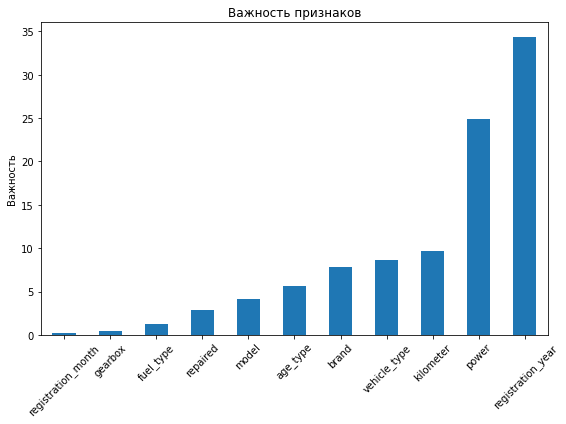

In [33]:
importance(model_c)

### Кодирование категориальных признаков с помощью OrdinalEncoder

In [34]:
%%time
enc = OrdinalEncoder()  
X_train_enc = X_train.copy()
X_valid_enc = X_valid.copy()
X_test_enc = X_test.copy()

X_train_enc[categorial] = enc.fit_transform(X_train_enc[categorial])
X_valid_enc[categorial] = enc.transform(X_valid_enc[categorial])
X_test_enc[categorial] = enc.transform(X_test_enc[categorial])

CPU times: total: 594 ms
Wall time: 587 ms


#### CatBoostRegressor

In [35]:
%%time
model_c_2 = CatBoostRegressor(random_state=10)  
model_c_2.fit(X_train_enc, y_train, verbose=100)  # Обучение модели

Learning rate set to 0.093766
0:	learn: 4335.8743552	total: 17.6ms	remaining: 17.6s
100:	learn: 1806.7315651	total: 1.53s	remaining: 13.6s
200:	learn: 1705.8340126	total: 3.05s	remaining: 12.1s
300:	learn: 1653.7920513	total: 4.56s	remaining: 10.6s
400:	learn: 1620.4095870	total: 6.06s	remaining: 9.06s
500:	learn: 1593.7819074	total: 7.56s	remaining: 7.53s
600:	learn: 1573.7002163	total: 9.04s	remaining: 6s
700:	learn: 1555.0771253	total: 10.5s	remaining: 4.5s
800:	learn: 1538.6965731	total: 12.1s	remaining: 2.99s
900:	learn: 1524.1616044	total: 13.6s	remaining: 1.49s
999:	learn: 1511.0102774	total: 15s	remaining: 0us
CPU times: total: 1min 48s
Wall time: 15.3 s


In [36]:
%%time
y_pred_c_2 = model_c_2.predict(X_valid_enc)  # Предсказание модели

CPU times: total: 125 ms
Wall time: 23.5 ms


In [37]:
print('RMSE модели:', rmse(y_valid, y_pred_c_2))

RMSE модели: 1608.0813622695264


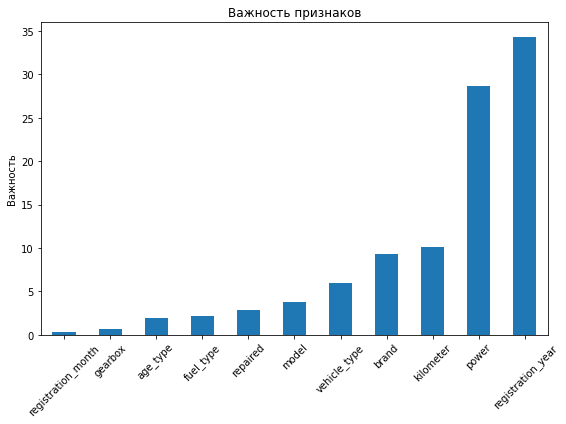

In [38]:
importance(model_c_2)

#### LGBMRegressor

In [39]:
%%time
model_l = LGBMRegressor(random_state=10)  
model_l.fit(X_train_enc, y_train)  # Обучение модели

CPU times: total: 4.5 s
Wall time: 631 ms


LGBMRegressor(random_state=10)

In [40]:
%%time
y_pred_l = model_l.predict(X_valid_enc)  # Предсказание модели

CPU times: total: 516 ms
Wall time: 80.9 ms


In [41]:
print('RMSE модели:', rmse(y_valid, y_pred_l))

RMSE модели: 1698.5293164633213


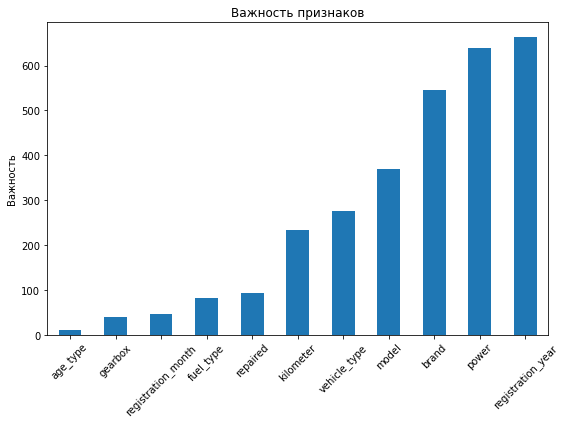

In [42]:
importance(model_l)

#### LGBMRegressor с внутренним методом кодировки данных + OrdinalEncoder

In [43]:
%%time
model_l_2 = LGBMRegressor(random_state=10)  
model_l_2.fit(X_train_enc, y_train, categorical_feature=[0, 2, 4, 7, 8, 9])  # Обучение модели

C:\Users\Ksiy\anaconda3\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


CPU times: total: 6.77 s
Wall time: 1.05 s


LGBMRegressor(random_state=10)

In [44]:
%%time
y_pred_l_2 = model_l_2.predict(X_valid_enc)  # Предсказание модели

CPU times: total: 781 ms
Wall time: 123 ms


In [45]:
print('RMSE модели:', rmse(y_valid, y_pred_l_2))

RMSE модели: 1618.5292614516022


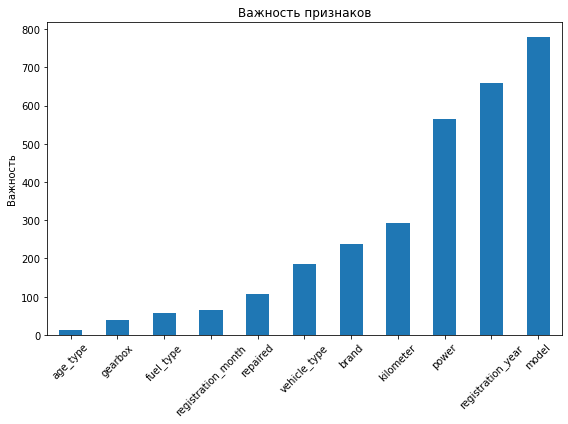

In [46]:
importance(model_l_2)

#### XGBRegressor

In [47]:
%%time
model_x =  XGBRegressor(random_state=10)  
model_x.fit(X_train_enc, y_train)  # Обучение модели

CPU times: total: 42.9 s
Wall time: 6.23 s


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=10, ...)

In [48]:
%%time
y_pred_x = model_x.predict(X_valid_enc)  # Предсказание модели

CPU times: total: 297 ms
Wall time: 59.9 ms


In [49]:
print('RMSE модели:', rmse(y_valid, y_pred_x))

RMSE модели: 1615.8831764983386


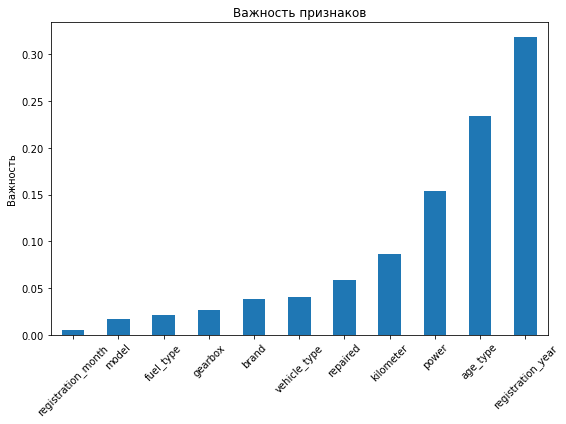

In [50]:
importance(model_x)

#### RandomForestRegressor

In [51]:
%%time
model_f = RandomForestRegressor(random_state=10) 
model_f.fit(X_train_enc, y_train)   # Обучение модели

CPU times: total: 1min 5s
Wall time: 1min 5s


RandomForestRegressor(random_state=10)

In [52]:
%%time
y_pred_f = model_f.predict(X_valid_enc)  # Предсказание модели

CPU times: total: 1.75 s
Wall time: 1.77 s


In [53]:
print('RMSE модели:', rmse(y_valid, y_pred_f))

RMSE модели: 1601.8734262011405


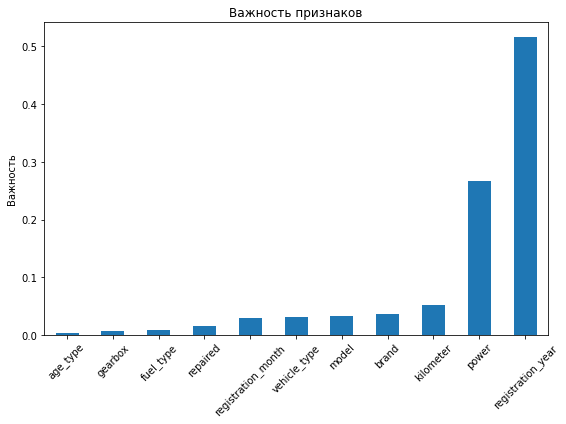

In [54]:
importance(model_f)

**Вывод:** Модели бустинга обучаются и делают предсказания в несколько раз быстрее модели случайного леса. Наиболее точной является модель CatBoostRegressor с внутренним методом кодировки данных, с RMSE = 1592.6590409166356, наиболее быстрой, но менее точной является модель LGBMRegressor с RMSE = 1698.5293164633213. Точность предсказаний можно повысить, используя одновременно OrdinalEncoder и внутренний метод кодировки LGBMRegressor. Время обучения повысилось, но RMSE уменьшилась: RMSE = 1618.5292614516022. Учитывая и скорость обучения, и точность предсказания, в качестве подходящей заказчику модели примем модель **LGBMRegressor(с внутренней кодировкой категориальных данных)**.

#### Подберем гиперпараметры для лучшей модели

In [55]:
%%time
params = {
    'n_estimators' : [100, 200],
    'max_depth' : [5, 7],
    'random_state': [10]
}
    
search = GridSearchCV(LGBMRegressor(), params, scoring=rmse_scorer)  # Подбор гиперпараметров по сетке
model = search.fit(X_train_enc, y_train, categorical_feature=[0, 2, 4, 7, 8, 9])
y_pred = model.predict(X_valid_enc)

print("Test RMSE = %.4f" % model.best_score_)
print( model.best_params_)

C:\Users\Ksiy\anaconda3\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


Test RMSE = -1575.8390
{'max_depth': 7, 'n_estimators': 200, 'random_state': 10}
CPU times: total: 2min 33s
Wall time: 20.1 s


## Тестирование модели

Проверим лучшую модель на тестовой выборке.

In [56]:
%%time
model = LGBMRegressor(n_estimators=200, max_depth=7, random_state=10)
model.fit(X_train_enc, y_train, categorical_feature=[0, 2, 4, 7, 8, 9])
y_pred = model.predict(X_test_enc)
print("Test RMSE = %.4f" % rmse(y_test, y_pred))

Test RMSE = 1568.1858
CPU times: total: 10.9 s
Wall time: 1.38 s


Проверим модель на вменияемость с помощью модели DummyRegressor, предсказывающей среднее значение.

In [57]:
model = DummyRegressor (strategy='mean')
model.fit(X_train_all, y_train_all)
y_pred = model.predict(X_test)
print (f'RMSE для модели DummyRegressor: {rmse(y_test, y_pred)}')

RMSE для модели DummyRegressor: 4616.4972206022885


**Вывод.** Выбранная модель прошла проверку на тестовой выборке; а также проверку на адекватность, показав результат лучше, чем результат DummyRegressor.

## Общий вывод

В результате работы был проведен исследовательский анализ данных, запонены пропуски, удалены выбросы. Признаки подготовлены к обучению моделей.\
Были обучены 4 разных модели: CatBoostRegressor, LGBMRegressor, XGBRegressor, RandomForestRegressor. Для каждой модели рассмотрены: время обучения, время предсказания, RMSE, важность призаков.
Из соображений скорости обучения и точности предсказания наилучшей была выбрана модель **LGBMRegressor с внутренним методом кодировки данных + OrdinalEncoder, с гиперпараметрами и метрикой:**
- n_estimators: 200
- max_depth: 7 
- RMSE: 1568.1858

Модель прошла проверку на адекватность, показав метрику RMSE выше, чем Dummy-модель, предсказывающая среднее.